In [1]:
import numpy as np
import torch as T
device = 'cpu'

In [2]:
def forward(x, w, b):
#     z = T.dot(x, w).reshape(1)
#     if(len(x) == 1 and len(w) == 1):
    z = x * w
#     else:
#         z = T.dot(x, w)
    z += b
    p = 1 / (1 + T.exp(-z))

    return p

In [3]:
seed = 0xEDA

In [4]:
print("Создадим данные")
T.manual_seed(seed)
np.random.seed(seed)

# 1. Модельные данные для обучения
# train_x = np.array([
#     [1.5, 2.5], [3.5, 4.5], [6.5, 6.5],
#     [4.5, 1.5], [5.5, 3.5], [7.5, 5.5]], dtype=np.float32)

train_x = np.array([
    -10, -8, -8.3, -7.6, -7, -6.5, -6, -5.5, -4.4, -4, -3, -2.4, -1.5, -0.75, 0.1, 0.22,
    -0.3, -0.1, 0.9, 1.7, 3, 4, 5.3, 5.5, 6 ,6.5, 7, 7.2, 8, 8.9, 9, 10
], dtype=np.float32)

len_train_x = len(train_x)

if(len_train_x % 2 != 0):
    print(len(train_x))
    assert(len_train_x % 2 == 0)

train_y = np.ones_like(train_x, dtype=np.float32)

for i in range(int(len_train_x / 2)):
    train_y[i] = 0

# train_y = np.array([
#     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

# ], dtype=np.float32)
if(len(train_x) != len(train_y)):
    print(len(train_x))
    print(len(train_y))
    assert(len(train_x) == len(train_y))


Создадим данные


In [5]:
print("Превратим в тензоры:")
print(train_x)
print(train_y)

train_x = T.tensor(train_x, dtype=T.float32).to(device)
train_y = T.tensor(train_y, dtype=T.long).to(device)


Превратим в тензоры:
[-10.    -8.    -8.3   -7.6   -7.    -6.5   -6.    -5.5   -4.4   -4.
  -3.    -2.4   -1.5   -0.75   0.1    0.22  -0.3   -0.1    0.9    1.7
   3.     4.     5.3    5.5    6.     6.5    7.     7.2    8.     8.9
   9.    10.  ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
# границы для случайной величины
lo = -0.01; hi = 0.01
w = T.rand((1), dtype=T.float32, requires_grad=True).to(device)
w = (hi - lo) * w + lo
w.grad = T.zeros(1)
w.retain_grad()

b = T.zeros((1), dtype=T.float32, requires_grad=True).to(device)
b.grad = T.zeros(1)
b.retain_grad()
print(w)
print(b)

tensor([-0.0059], grad_fn=<AddBackward0>)
tensor([0.], requires_grad=True)


In [7]:
print("Обучение")

lrn_rate = 0.05
indices = np.arange(18)

N = 1000

w_evolution = np.array([])

prev_tot_loss = 1000
tot_loss = 0
# for epoch in range(0, N):
epoch = 0
while(abs(prev_tot_loss - tot_loss) > 1e-7):
    
    prev_tot_loss = tot_loss
    tot_loss = 0
    tot_loss = T.zeros((1), dtype=T.float32, requires_grad=True).to(device)
    tot_loss.grad = T.zeros(1)
    tot_loss.retain_grad()
    
    np.random.shuffle(indices)  
    for ii in range(len(indices)):
        i = indices[ii]
        x = train_x[i]
        target = train_y[i]

        oupt = forward(x, w, b)
        loss = (oupt - target).pow(2).sum()
        tot_loss = loss+tot_loss

#     tot_loss = tot_loss + T.norm(w, p=2) # l2 reg
#     tot_loss = tot_loss + T.norm(w, p=1) # l1 reg

    tot_loss.backward(retain_graph=True)  # compute gradients

    w.data += -1 * lrn_rate * w.grad.data
    b.data += -1 * lrn_rate * b.grad.data
    w.grad = T.zeros(1)
    b.grad = T.zeros(1)

#     w_evolution[epoch, 0] = w[0]
    np.append(w_evolution, w[0].detach().numpy())

#     print("epoch = %4d " % epoch, end="")
#     print("   loss = %6.4f" % (tot_loss / 6))
#     print(tot_loss)    
#     print("=========================================")
    
    if epoch % 100 == 0:
        print("epoch = %4d " % epoch, end="")
        print("   loss = %6.4f" % (tot_loss / 6))
        print(tot_loss - prev_tot_loss)
        
        print("=========================================")
    epoch +=1

Обучение
epoch =    0    loss = 0.7686
tensor([4.6113], grad_fn=<SubBackward0>)
epoch =  100    loss = 0.2162
tensor([-1.0848e-05], grad_fn=<SubBackward0>)
epoch =  200    loss = 0.2162
tensor([-7.1526e-07], grad_fn=<SubBackward0>)


w:  tensor([0.8565], grad_fn=<AddBackward0>)
b:  tensor([-0.3950], requires_grad=True)
[-10.    -8.    -8.3   -7.6   -7.    -6.5   -6.    -5.5   -4.4   -4.
  -3.    -2.4   -1.5   -0.75   0.1    0.22]
[-0.3 -0.1  0.9  1.7  3.   4.   5.3  5.5  6.   6.5  7.   7.2  8.   8.9
  9.  10. ]


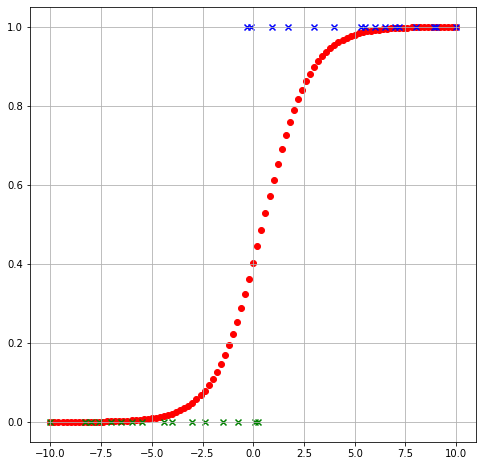

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(
    nrows=1, ncols=1,
    figsize=(8, 8)
)
x = np.linspace(-10, 10, 101)

x = T.tensor(x, dtype=T.float32).to(device)

print("w: ", w)
print("b: ", b)

y = forward(x, w, b)
y = y.detach().numpy()
ax1.scatter(x, y, marker='o', c='r')

pack_0 = np.zeros((int(len(x) / 2), 2))
pack_1 = np.zeros((int(len(x) / 2), 2))

train_x_numpy = train_x.numpy()
train_y_numpy = train_y.numpy()

pack_0 = train_x_numpy[train_y_numpy == 0]
pack_1 = train_x_numpy[train_y_numpy == 1]

print(pack_0)
print(pack_1)

ax1.scatter(pack_0, np.zeros_like(pack_0), marker='x', c='g')
ax1.scatter(pack_1, np.ones_like(pack_1), marker='x', c='b')

plt.grid()